In [ ]:
# System dependencies
!apt-get install -y cmake build-essential libgmp-dev

# Core Python libraries
!pip install numpy pandas scikit-learn xgboost imbalanced-learn

# Homomorphic encryption libraries
!pip install pyfhel tenseal==0.3.16 phe

# Federated learning framework
!pip install syft==0.8.5


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
The following additional packages will be installed:
  libgmpxx4ldbl
Suggested packages:
  gmp-doc libgmp10-doc libmpfr-dev
The following NEW packages will be installed:
  libgmp-dev libgmpxx4ldbl
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 346 kB of archives.
After this operation, 1,702 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmpxx4ldbl amd64 2:6.2.1+dfsg-3ubuntu1 [9,580 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmp-dev amd64 2:6.2.1+dfsg-3ubuntu1 [337 kB]
Fetched 346 kB in 1s (556 kB/s)
Selecting previously unselected package libgmpxx4ldbl:amd64.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack .../libgmpxx4ldbl_

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.1/789.1 kB 32.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.4/549.4 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.5/394.5 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.9/698.9 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from Pyfhel import Pyfhel
from sklearn.metrics import roc_auc_score

class SecureBoostUnified:
    """
    A dynamic Federated SecureBoost classifier that supports any number of passive parties.
    Parties are identified by their index in the input list (0, 1, 2, etc.).
    """

    def __init__(self, rounds=50, bins=8, lr=0.1, lmbda=1.0, gamma=0.0):
        self.rounds = rounds
        self.bins = bins
        self.lr = lr
        self.lmbda = lmbda
        self.gamma = gamma
        self.trees_ = []
        self.initial_pred_ = 0.0
        self.history_ = {'train_auc': []}

        print("Initializing Homomorphic Encryption context...")
        self.HE = Pyfhel()
        self.HE.contextGen(scheme='ckks', n=8192, scale=2**40, qi_sizes=[60, 40, 40, 60])
        self.HE.keyGen()
        self.HE.relinKeyGen()
        print("HE Context Ready. 🔒")

    def _compute_grad_hess(self, y_true, y_pred_log_odds):
        prob = 1 / (1 + np.exp(-y_pred_log_odds))
        return prob - y_true, prob * (1 - prob)

    def _encrypt_vector(self, val):
        return self.HE.encrypt(np.array([val]))

    def _decrypt_scalar(self, ctxt):
        return self.HE.decrypt(ctxt)[0]

    def _compute_leaf_weight(self, G, H):
        return -G / (H + self.lmbda)

    def _compute_gain(self, GL, HL, GR, HR):
        return 0.5 * ((GL**2)/(HL+self.lmbda) + (GR**2)/(HR+self.lmbda) - ((GL+GR)**2)/(HL+HR+self.lmbda)) - self.gamma

    def _compute_encrypted_histograms(self, X_df, enc_g, enc_h):
        """Computes encrypted histograms for a single party's data."""
        n_feats = X_df.shape[1]
        enc_g_sums = [[self._encrypt_vector(0.0) for _ in range(self.bins)] for _ in range(n_feats)]
        enc_h_sums = [[self._encrypt_vector(0.0) for _ in range(self.bins)] for _ in range(n_feats)]
        bin_edges_all = []

        for j in range(n_feats):
            col_vals = X_df.iloc[:, j]
            unique_edges = np.unique(np.quantile(col_vals, np.linspace(0, 1, self.bins + 1)))
            if len(unique_edges) < 2:
                 unique_edges = np.array([col_vals.min(), col_vals.max()])
                 if len(np.unique(unique_edges)) < 2:
                     unique_edges = np.array([unique_edges[0]-0.5, unique_edges[0]+0.5])

            bin_edges_all.append(unique_edges)
            num_bins = len(unique_edges) - 1
            bin_indices = np.digitize(col_vals, bins=unique_edges)

            for i in range(len(col_vals)):
                b_idx = np.clip(bin_indices[i] - 1, 0, num_bins - 1)
                if b_idx < len(enc_g_sums[j]):
                    enc_g_sums[j][b_idx] += enc_g[i]
                    enc_h_sums[j][b_idx] += enc_h[i]
        return enc_g_sums, enc_h_sums, bin_edges_all

    def _find_best_split(self, enc_g_sums, enc_h_sums, bin_edges_all, party_idx):
        """Finds the best split for a single party."""
        best = {"gain": -np.inf}
        for j in range(len(enc_g_sums)):
            if len(bin_edges_all[j]) < 2: continue
            dec_g = [self._decrypt_scalar(g) for g in enc_g_sums[j]]
            dec_h = [self._decrypt_scalar(h) for h in enc_h_sums[j]]
            G_prefix = np.cumsum(dec_g)
            H_prefix = np.cumsum(dec_h)
            if len(G_prefix) == 0: continue
            G_total, H_total = G_prefix[-1], H_prefix[-1]

            for i in range(len(bin_edges_all[j]) - 2):
                if i >= len(G_prefix): break
                GL, HL = G_prefix[i], H_prefix[i]
                GR, HR = G_total - GL, H_total - HL
                if HL <= 0 or HR <= 0: continue
                gain = self._compute_gain(GL, HL, GR, HR)
                if gain > best['gain']:
                    best = {
                        'gain': gain, 'party_idx': party_idx, 'feature_idx': j,
                        'threshold': bin_edges_all[j][i+1],
                        'left_stats': (GL, HL), 'right_stats': (GR, HR)
                    }
        return best

    def fit(self, X_parties_train, y_train):
        """
        X_parties_train: List of DataFrames, one for each passive party.
                         e.g., [XA_train, XB_train] OR [XA, XB, XC, XD]
        """
        y_np = y_train.values if isinstance(y_train, pd.Series) else y_train
        self.initial_pred_ = np.log(np.mean(y_np) / (1 - np.mean(y_np)))
        preds = np.full(len(y_np), self.initial_pred_)
        n_parties = len(X_parties_train)
        print(f"Starting training with {n_parties} passive parties.")

        for r in range(self.rounds):
            print(f"--- Round {r+1}/{self.rounds} ---")
            g, h = self._compute_grad_hess(y_np, preds)
            enc_g = [self._encrypt_vector(val) for val in g]
            enc_h = [self._encrypt_vector(val) for val in h]

            # 1. Passive parties compute histograms (in loop instead of hardcoded)
            party_responses = []
            for i, X_party in enumerate(X_parties_train):
                # Passive party 'i' computes its encrypted histograms
                hist_response = self._compute_encrypted_histograms(X_party, enc_g, enc_h)
                # Active party finds best split for this specific party's response
                best_p = self._find_best_split(*hist_response, party_idx=i)
                party_responses.append(best_p)

            # 2. Find global best among all parties
            global_best = max(party_responses, key=lambda x: x['gain'])

            if global_best['gain'] <= -1e8:
                print("No further improvement possible. Stopping early.")
                break

            p_idx = global_best['party_idx']
            f_idx = global_best['feature_idx']
            print(f"Best split: Party {p_idx}, Feat {f_idx}, Gain {global_best['gain']:.4f}")

            # 3. Update predictions
            feat_vals = X_parties_train[p_idx].iloc[:, f_idx].values
            mask_left = feat_vals <= global_best['threshold']
            w_L = self._compute_leaf_weight(*global_best['left_stats'])
            w_R = self._compute_leaf_weight(*global_best['right_stats'])

            preds[mask_left] += self.lr * w_L
            preds[~mask_left] += self.lr * w_R

            self.trees_.append({
                'party_idx': p_idx,
                'feature_idx': f_idx,
                'threshold': global_best['threshold'],
                'w_left': w_L, 'w_right': w_R
            })
            self.history_['train_auc'].append(roc_auc_score(y_np, 1/(1+np.exp(-preds))))

        return self

    def predict_proba(self, X_parties_test):
        """
        X_parties_test: List of DataFrames, must match order used in fit().
        """
        # Use the first party's data just to determine number of samples
        n_samples = len(X_parties_test[0])
        preds = np.full(n_samples, self.initial_pred_)

        for tree in self.trees_:
            # Dynamically select the correct party's dataframe based on index
            p_idx = tree['party_idx']
            feat_vals = X_parties_test[p_idx].iloc[:, tree['feature_idx']].values
            mask_left = feat_vals <= tree['threshold']

            preds[mask_left] += self.lr * tree['w_left']
            preds[~mask_left] += self.lr * tree['w_right']

        probs = 1 / (1 + np.exp(-preds))
        return np.vstack([1-probs, probs]).T


📂 Loading and preparing data for benchmark...
⚖️ Applying SMOTE to reach 1120 samples...
✅ Benchmark Data Ready: (1120, 48) (Samples x Features)

🔧 Initializing HE Context (Active Party)...
Initializing Homomorphic Encryption context...
HE Context Ready. 🔒
🔒 Encrypting dummy gradients for 1120 samples (One-time cost)...
   Active Party Encryption took: 22.01s

📊 2-Party Split: 24 features/party
📊 4-Party Split: ~12 features/party

⏱️ Running 2-Party Benchmark...
   Party 0 finished in 9.53s
   Party 1 finished in 9.17s
   >>> 2-Party Results: Serial=18.70s | Parallel Est=9.53s

⏱️ Running 4-Party Benchmark...
   Party 0 finished in 4.00s
   Party 1 finished in 3.90s
   Party 2 finished in 4.59s
   Party 3 finished in 4.16s
   >>> 4-Party Results: Serial=16.65s | Parallel Est=4.59s



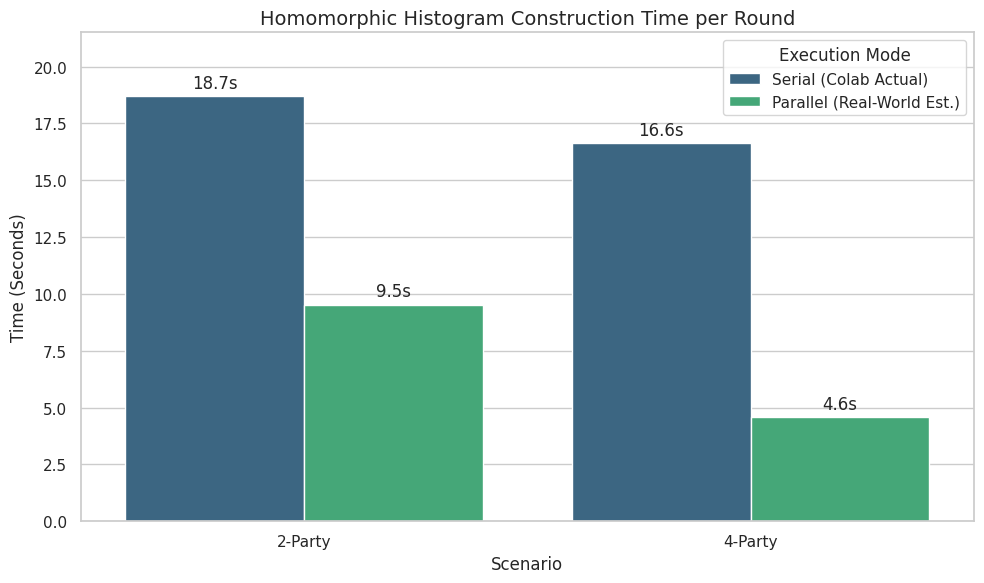

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from Pyfhel import Pyfhel

# --- Ensure Unified Class is available for benchmarking ---
# (Paste the SecureBoostUnified class here if you haven't run it yet)
# If you already ran the cell with SecureBoostUnified, you can skip re-pasting it.

sns.set_theme(style="whitegrid")

# ==========================================
# 1. DATA PREPARATION (Standardized to 1120 samples)
# ==========================================
print("📂 Loading and preparing data for benchmark...")
try:
    df = pd.read_csv('/content/final_preprocessed_german_credit.csv')
    X = df.drop(columns=['target'])
    y = df['target']
    # Initial split to get standard training set
    X_train_raw, _, y_train_raw, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Apply SMOTE to match the exact workload of your 4-party experiment
    print("⚖️ Applying SMOTE to reach 1120 samples...")
    smote = SMOTE(random_state=42)
    X_bench, _ = smote.fit_resample(X_train_raw, y_train_raw)
    print(f"✅ Benchmark Data Ready: {X_bench.shape} (Samples x Features)\n")

except FileNotFoundError:
    print("❌ Data not found. Generating dummy 1120x48 data for benchmark.")
    X_bench = pd.DataFrame(np.random.rand(1120, 48), columns=[f'f{i}' for i in range(48)])

# ==========================================
# 2. HE SETUP & DUMMY INPUTS
# ==========================================
print("🔧 Initializing HE Context (Active Party)...")
# We use the unified class for easiest benchmarking
model = SecureBoostUnified(rounds=1, bins=8)

n_samples = X_bench.shape[0]
print(f"🔒 Encrypting dummy gradients for {n_samples} samples (One-time cost)...")
# Generate dummy data for one round
g_dummy = np.random.uniform(-0.5, 0.5, n_samples)
h_dummy = np.random.uniform(0.1, 0.25, n_samples)

t0 = time.time()
# Pre-encrypt these. In a real round, Active party does this once and sends to all.
enc_g = [model._encrypt_vector(val) for val in g_dummy]
enc_h = [model._encrypt_vector(val) for val in h_dummy]
print(f"   Active Party Encryption took: {time.time() - t0:.2f}s\n")

# ==========================================
# 3. DEFINE SPLITS
# ==========================================
cols = X_bench.columns.tolist()
n_feats = len(cols)

# 2-Party Split
mid = n_feats // 2
X2 = [X_bench[cols[:mid]], X_bench[cols[mid:]]]

# 4-Party Split
q = n_feats // 4
X4 = [X_bench[cols[:q]], X_bench[cols[q:2*q]],
      X_bench[cols[2*q:3*q]], X_bench[cols[3*q:]]]

print(f"📊 2-Party Split: {X2[0].shape[1]} features/party")
print(f"📊 4-Party Split: ~{X4[0].shape[1]} features/party\n")

# ==========================================
# 4. BENCHMARK LOOP
# ==========================================
def run_benchmark(party_data_list, label):
    print(f"⏱️ Running {label} Benchmark...")
    times = []
    for i, X_party in enumerate(party_data_list):
        t_start = time.time()
        # --- CRITICAL STEP: Measure ONLY the homomorphic histogram building ---
        model._compute_encrypted_histograms(X_party, enc_g, enc_h)
        # --------------------------------------------------------------------
        times.append(time.time() - t_start)
        print(f"   Party {i} finished in {times[-1]:.2f}s")

    total_serial = sum(times)
    max_parallel = max(times)
    print(f"   >>> {label} Results: Serial={total_serial:.2f}s | Parallel Est={max_parallel:.2f}s\n")
    return total_serial, max_parallel

# Run Benchmarks
serial_2, parallel_2 = run_benchmark(X2, "2-Party")
serial_4, parallel_4 = run_benchmark(X4, "4-Party")

# ==========================================
# 5. VISUALIZATION
# ==========================================
results = pd.DataFrame({
    'Scenario': ['2-Party', '2-Party', '4-Party', '4-Party'],
    'Execution Mode': ['Serial (Colab Actual)', 'Parallel (Real-World Est.)',
                       'Serial (Colab Actual)', 'Parallel (Real-World Est.)'],
    'Time (s)': [serial_2, parallel_2, serial_4, parallel_4]
})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results, x='Scenario', y='Time (s)', hue='Execution Mode', palette='viridis')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1fs', padding=3)

plt.title("Homomorphic Histogram Construction Time per Round", fontsize=14)
plt.ylabel("Time (Seconds)")
plt.ylim(0, max(serial_2, serial_4) * 1.15)
plt.tight_layout()
plt.show()

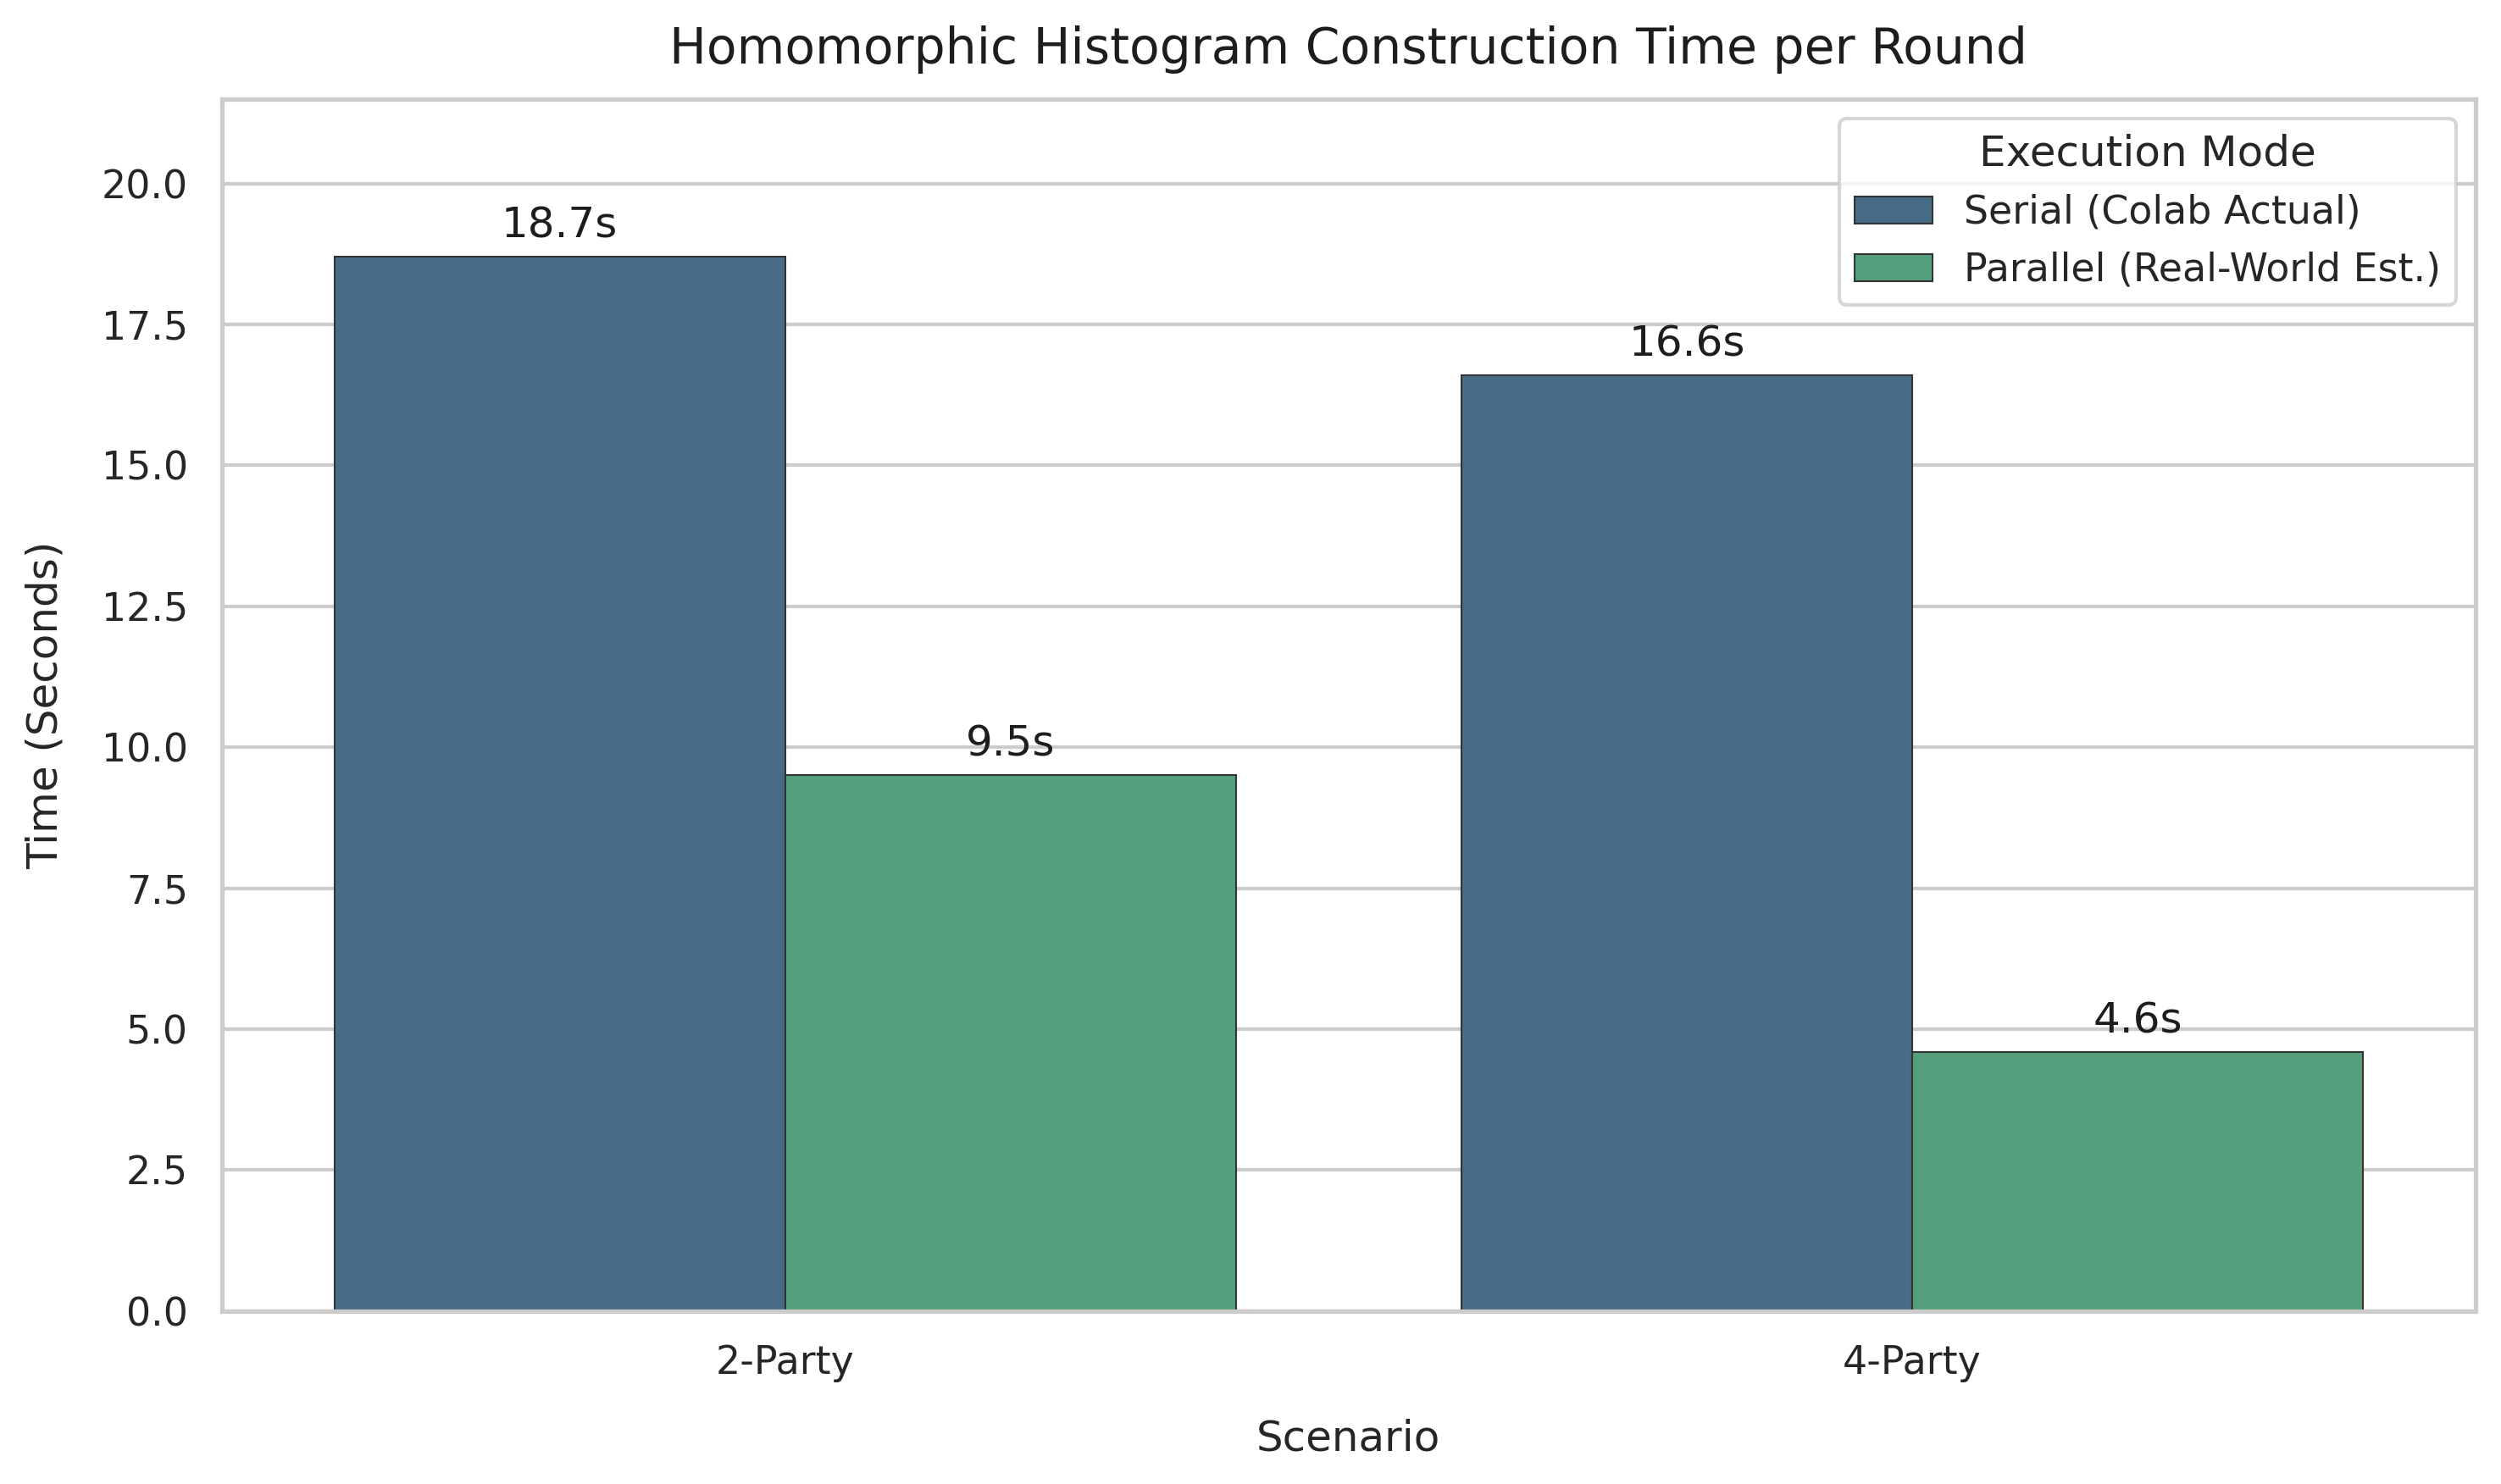

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Setup Data
# Creating a DataFrame in 'long' format which works best with Seaborn
data = {
    'Scenario': ['2-Party', '2-Party', '4-Party', '4-Party'],
    'Execution Mode': [
        'Serial (Colab Actual)',
        'Parallel (Real-World Est.)',
        'Serial (Colab Actual)',
        'Parallel (Real-World Est.)'
    ],
    'Time (Seconds)': [18.7, 9.5, 16.6, 4.6]
}
df = pd.DataFrame(data)

# 2. Styling Setup
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6)) # Adjust figure size to match aspect ratio

# Define custom colors to match the image closely
# Dark blue-gray for Serial, Medium green for Parallel
custom_palette = ["#3b6e8f", "#49ab7b"]

# 3. Create the Bar Plot
ax = sns.barplot(
    data=df,
    x='Scenario',
    y='Time (Seconds)',
    hue='Execution Mode',
    palette=custom_palette,
    edgecolor=".2", # Adds a very slight border sometimes seen in high-res renders
    linewidth=0.5
)

# 4. Customize Annotations (The text on top of bars)
# Iterate through the containers (groups of bars) to add labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1fs', padding=3, fontsize=12, color='#1d1d1d')

# 5. Fine-tuning Layout and Labels
ax.set_title("Homomorphic Histogram Construction Time per Round", fontsize=14, pad=10, color='#1d1d1d')
ax.set_xlabel("Scenario", fontsize=12, labelpad=10)
ax.set_ylabel("Time (Seconds)", fontsize=12, labelpad=10)

# Custom Y-axis ticks to match the 2.5 increments seen in the image
ax.set_yticks(np.arange(0, 22.5, 2.5))
ax.set_ylim(0, 21.5) # Set upper limit slightly higher for labels

# Customize Legend
plt.legend(title='Execution Mode', title_fontsize=12, fontsize=11, loc='upper right', frameon=True, fancybox=True)

# Customize tick parameters for a cleaner look
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# 6. Show Plot
plt.tight_layout()
plt.show()

Plot saved as PDF/PNG with new X-axis label


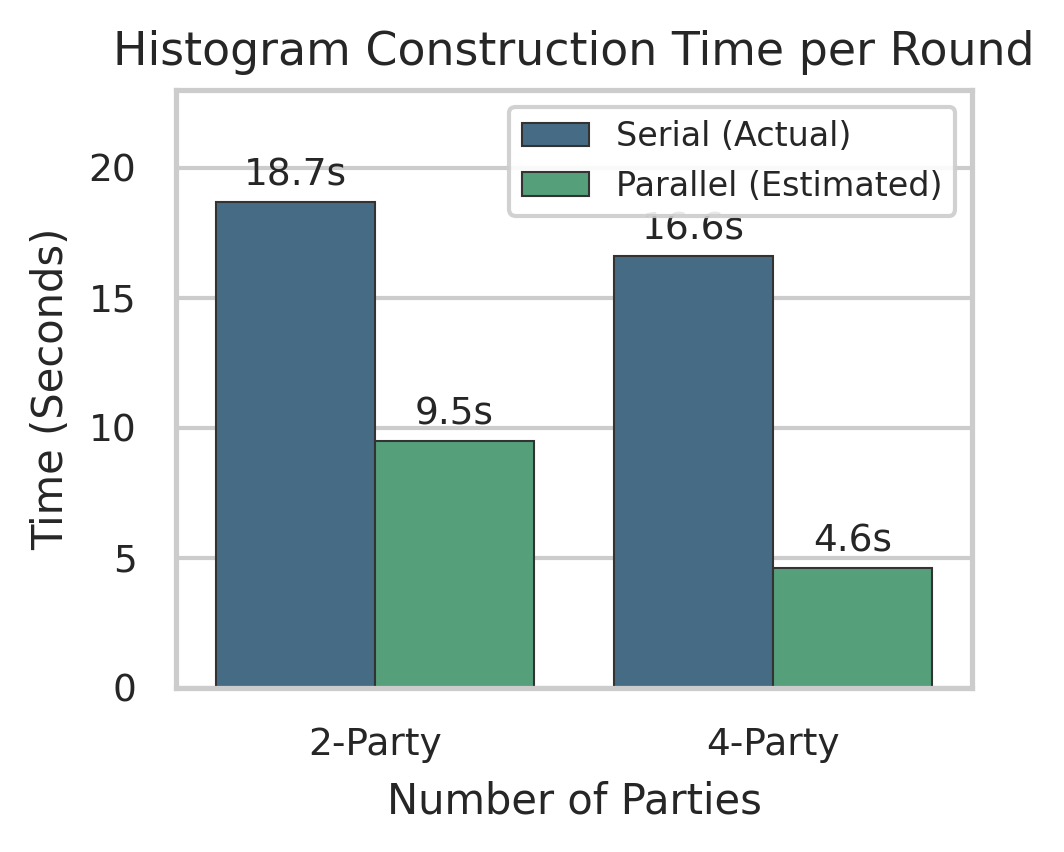

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Setup Data
data = {
    'Number of Parties': ['2-Party', '2-Party', '4-Party', '4-Party'], # Changed column name
    'Execution Mode': [
        'Serial (Actual)',
        'Parallel (Estimated)',
        'Serial (Actual)',
        'Parallel (Estimated)'
    ],
    'Time (Seconds)': [18.7, 9.5, 16.6, 4.6]
}
df = pd.DataFrame(data)

# 2. Styling Setup for IEEE Single Column
sns.set_theme(style="whitegrid")
plt.figure(figsize=(3.5, 3))

# Custom colors
custom_palette = ["#3b6e8f", "#49ab7b"]

# 3. Create the Bar Plot
ax = sns.barplot(
    data=df,
    x='Number of Parties', # Updated x-axis data source
    y='Time (Seconds)',
    hue='Execution Mode',
    palette=custom_palette,
    edgecolor=".2",
    linewidth=0.5
)

# 4. Annotations
for container in ax.containers:
    ax.bar_label(container, fmt='%.1fs', padding=2, fontsize=9)

# 5. Fine-tuning Layout
ax.set_title("Histogram Construction Time per Round", fontsize=11)
ax.set_xlabel("Number of Parties", fontsize=10) # Updated X-axis label
ax.set_ylabel("Time (Seconds)", fontsize=10)

# Y-axis ticks
ax.set_yticks(np.arange(0, 25, 5))
ax.set_ylim(0, 23)

# Customize Legend
plt.legend(title='', fontsize=8, loc='upper right', framealpha=0.9)

# Tick parameters
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# 6. Save and Show
plt.tight_layout()
plt.savefig('histogram_time.pdf', format='pdf', bbox_inches='tight')
plt.savefig('histogram_time.png', dpi=600, bbox_inches='tight')

print("Plot saved as PDF/PNG with new X-axis label")
plt.show()